✅ 기존 FAISS 인덱스 파일이 존재합니다: faiss_index.faiss
❌ 기존 FAISS 인덱스를 로드하는 중 오류 발생: Error in __int64 __cdecl faiss::DirectMap::get(__int64) const at D:\bld\faiss-split_1734618091746\work\faiss\invlists\DirectMap.cpp:82: direct map not initialized
⚙️ 새로운 FAISS 인덱스를 생성합니다.
📊 평균 실루엣 계수: 0.0734


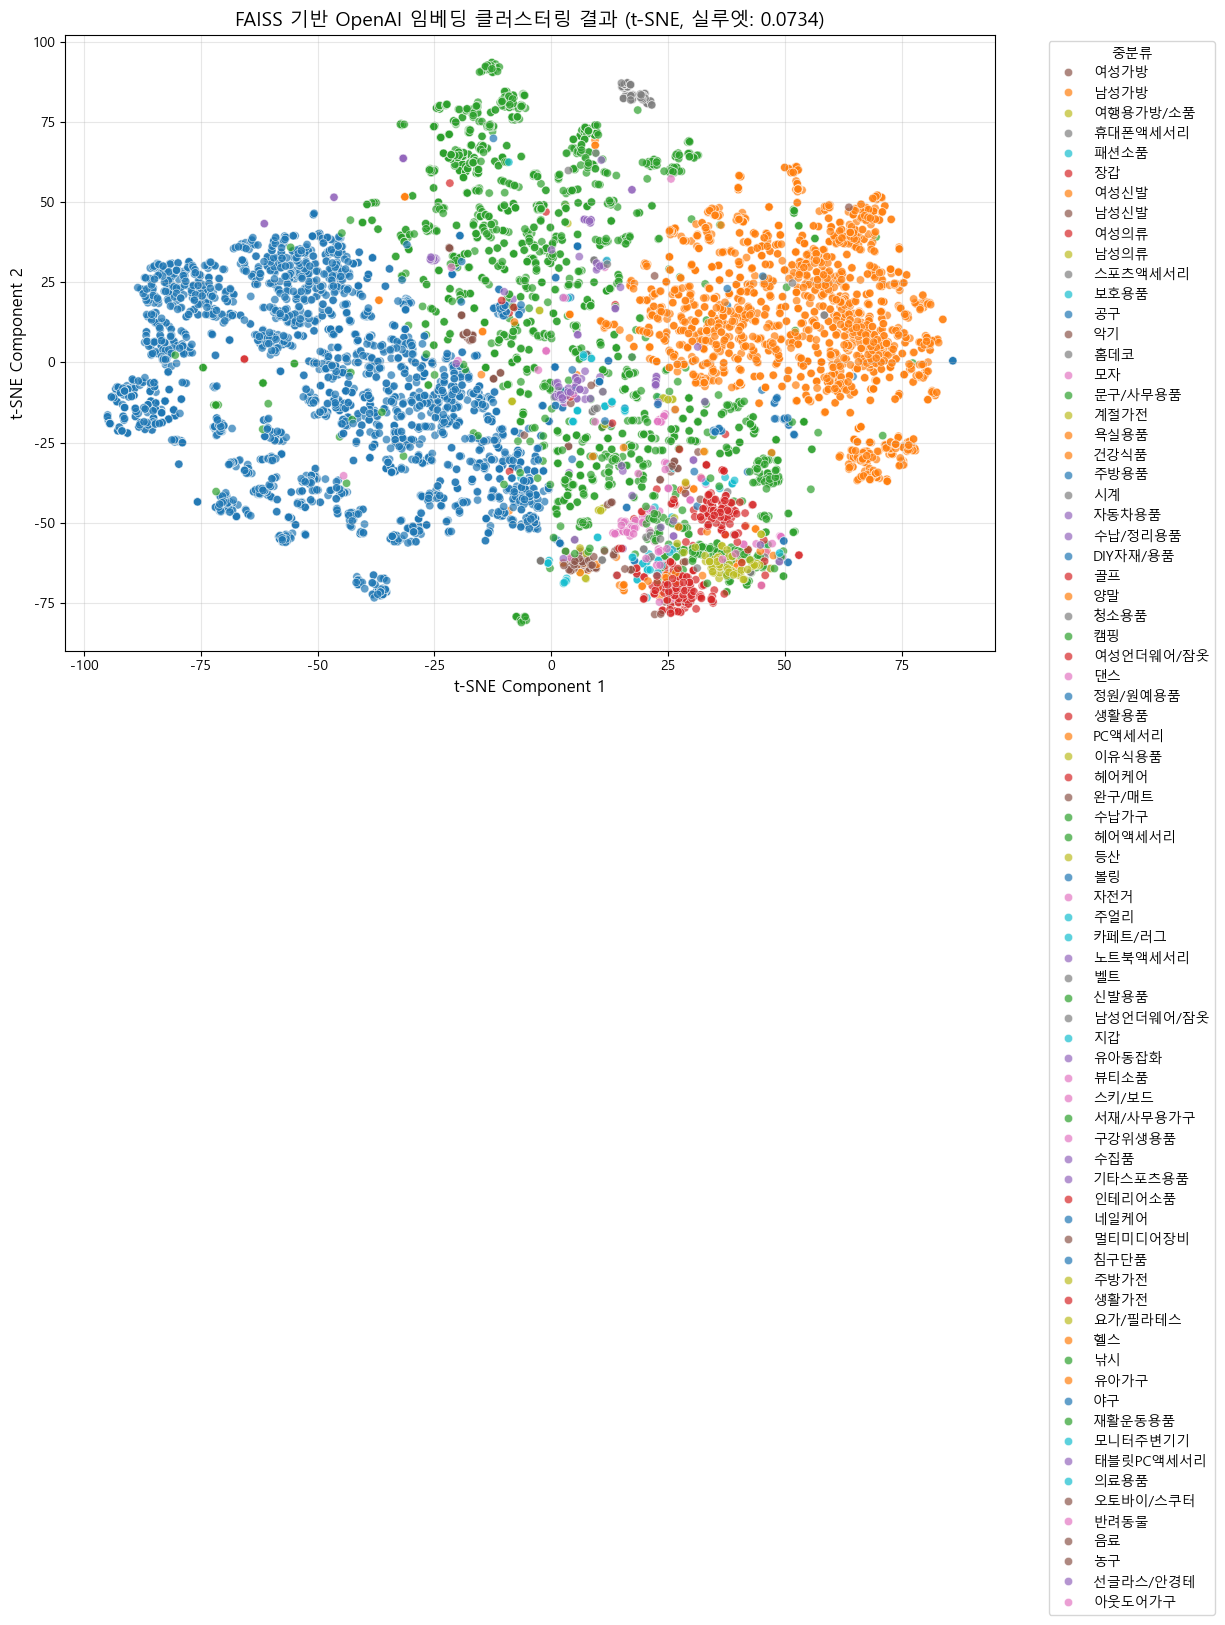

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import faiss
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings

# ✅ 엑셀 파일 경로 및 FAISS 파일 경로 설정
file_path = "db/오너클랜_클러스터링_0203.xlsx"
faiss_file_path = "faiss_index.faiss"

# ✅ 환경 변수 로드
load_dotenv()
API_KEY = os.getenv('OPENAI_API_KEY')

# ✅ FAISS 인덱스 저장/로드 함수
def save_faiss_index(index, file_path):
    faiss.write_index(index, file_path)

def load_faiss_index(file_path):
    return faiss.read_index(file_path)

# ✅ 엑셀 파일 로드 및 텍스트 변환
def load_excel_to_texts(file_path):
    data = pd.read_excel(file_path)
    texts = data['원본상품명'].dropna().tolist()
    return texts, data

# ✅ FAISS 인덱스 생성 및 저장
def create_and_save_faiss_index(file_path, faiss_file_path):
    try:
        texts, data = load_excel_to_texts(file_path)
        임베딩 = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=API_KEY)
        embeddings = 임베딩.embed_documents(texts)
        embeddings = np.array(embeddings, dtype=np.float32)
        faiss.normalize_L2(embeddings)

        # ✅ IndexIVFFlat 생성 및 DirectMap 활성화
        d = embeddings.shape[1]
        nlist = 200  # 클러스터 개수
        quantizer = faiss.IndexFlatL2(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
        index.maintain_direct_map = True  # DirectMap 활성화
        index.train(embeddings)
        index.add(embeddings)

        # ✅ FAISS 인덱스 저장
        save_faiss_index(index, faiss_file_path)
        return index, embeddings, data
    except Exception as e:
        print(f"❌ FAISS 인덱스 생성 및 저장 오류: {e}")
        return None, None, None



# ✅ FAISS 인덱스 생성 또는 로드
if not os.path.exists(faiss_file_path):
    print(f"⚙️ 새로운 FAISS 인덱스를 생성합니다: {faiss_file_path}")
    faiss_index, embeddings_matrix, df = create_and_save_faiss_index(file_path, faiss_file_path)
else:
    try:
        print(f"✅ 기존 FAISS 인덱스 파일이 존재합니다: {faiss_file_path}")
        faiss_index = load_faiss_index(faiss_file_path)
        faiss_index.maintain_direct_map = True  # DirectMap 활성화
        embeddings_matrix = np.array([faiss_index.reconstruct(i) for i in range(faiss_index.ntotal)])
        _, df = load_excel_to_texts(file_path)
    except RuntimeError as e:
        print(f"❌ 기존 FAISS 인덱스를 로드하는 중 오류 발생: {e}")
        print("⚙️ 새로운 FAISS 인덱스를 생성합니다.")
        faiss_index, embeddings_matrix, df = create_and_save_faiss_index(file_path, faiss_file_path)

# ✅ '카테고리명'에서 중분류 추출
df['중분류'] = df['카테고리명'].str.split('>').str[1]

# ✅ 카테고리별 색상 매핑
category_counts = df['중분류'].value_counts()
unique_categories = category_counts.index
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}
df['색상'] = df['중분류'].map(category_colors)

# ✅ 한글 폰트 설정 (Windows: Malgun Gothic, macOS: AppleGothic)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# ✅ K-Means 클러스터링 적용
num_clusters = 5  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_matrix)
df['Cluster'] = cluster_labels

# ✅ 실루엣 계수 계산
silhouette_avg = silhouette_score(embeddings_matrix, cluster_labels)
print(f"📊 평균 실루엣 계수: {silhouette_avg:.4f}")

# ✅ t-SNE를 활용한 차원 축소 (2D 시각화)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)
df[['TSNE1', 'TSNE2']] = reduced_embeddings

# ✅ 클러스터링 결과 시각화 (색상 포함)
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='TSNE1',
    y='TSNE2',
    hue='중분류',  # 카테고리를 기준으로 색상 구분
    palette=category_colors,
    data=df,
    alpha=0.7
)

# ✅ 그래프 설정
plt.title(f"FAISS 기반 OpenAI 임베딩 클러스터링 결과 (t-SNE, 실루엣: {silhouette_avg:.4f})", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="중분류", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score

# ✅ 실루엣 계수 계산
# K-Means 클러스터 레이블을 기준으로 실루엣 계수 계산
silhouette_avg = silhouette_score(embeddings_matrix, df['Cluster'])  # Cluster 기준으로 계산
df['Silhouette'] = silhouette_samples(embeddings_matrix, df['Cluster'])

print(f"📊 평균 실루엣 계수: {silhouette_avg:.4f}")

# ✅ 중분류별 평균 실루엣 계수 계산
category_silhouettes = df.groupby('중분류')['Silhouette'].mean()

# ✅ 시각화 - 실루엣 계수 분포
plt.figure(figsize=(12, 8))
sns.barplot(x=category_silhouettes.index, y=category_silhouettes.values, palette="viridis")
plt.xticks(rotation=90)  # X축 라벨 회전
plt.title("중분류별 평균 실루엣 계수", fontsize=14)
plt.xlabel("중분류", fontsize=12)
plt.ylabel("평균 실루엣 계수", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

NameError: name 'embeddings_matrix' is not defined

In [ ]:
# ✅ "악기" 관련 상품 필터링
instrument_categories = df[df['중분류'].str.contains("악기", na=False, case=False)]  # "악기" 포함된 중분류만 선택

# ✅ 중분류별 개수 계산
instrument_counts = instrument_categories['중분류'].value_counts()

# ✅ 결과 출력
print(instrument_counts)

NameError: name 'df' is not defined

In [ ]:
df

NameError: name 'df' is not defined

📊 평균 실루엣 계수: 0.0586


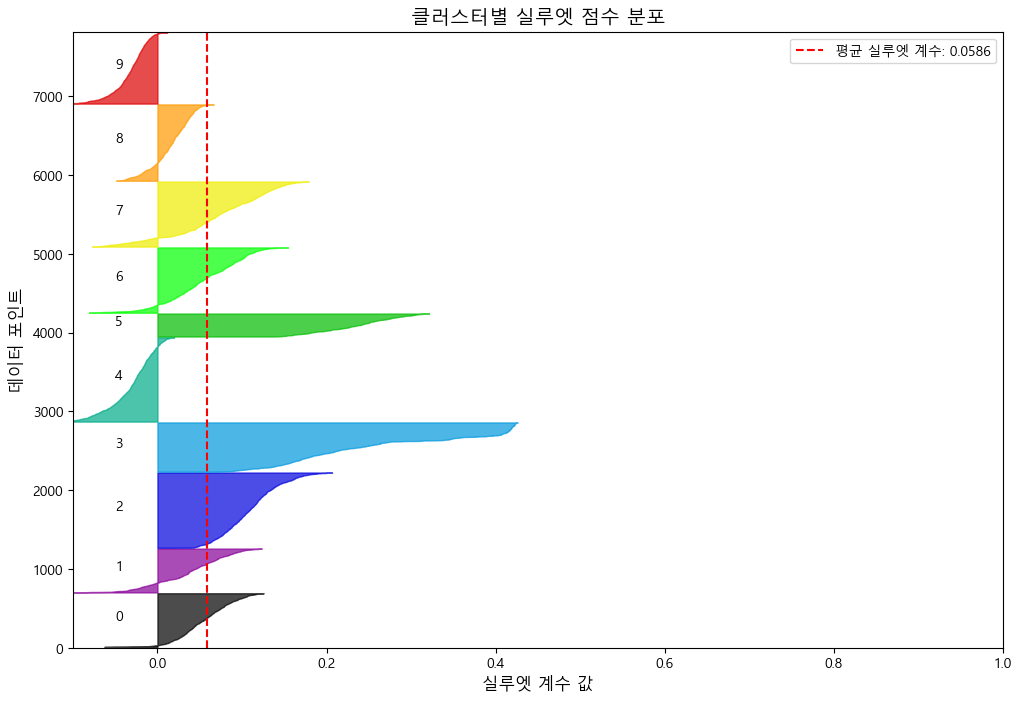

In [12]:
def visualize_silhouette(data, cluster_labels, n_clusters):
    """
    실루엣 계수를 계산하고, 클러스터별 실루엣 분포를 시각화합니다.
    
    Parameters:
        data (array-like): 클러스터링에 사용된 데이터 (예: 임베딩 벡터)
        cluster_labels (array-like): 각 데이터 포인트의 클러스터 레이블
        n_clusters (int): 클러스터 개수
    """
    # ✅ 실루엣 계수 계산
    silhouette_avg = silhouette_score(data, cluster_labels)
    sample_silhouette_values = silhouette_samples(data, cluster_labels)

    print(f"📊 평균 실루엣 계수: {silhouette_avg:.4f}")

    # ✅ 시각화 준비
    fig, ax = plt.subplots(figsize=(12, 8))
    y_lower = 10

    for i in range(n_clusters):
        # 해당 클러스터의 실루엣 점수 추출
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        # 클러스터별 높이 계산
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # 클러스터별 색상
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)

        # 클러스터 레이블 추가
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  # 다음 클러스터를 위한 시작점

    # ✅ 그래프 설정
    ax.set_title("클러스터별 실루엣 점수 분포", fontsize=14)
    ax.set_xlabel("실루엣 계수 값", fontsize=12)
    ax.set_ylabel("데이터 포인트", fontsize=12)
    ax.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"평균 실루엣 계수: {silhouette_avg:.4f}")
    ax.legend(loc='best')
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(data) + (n_clusters + 1) * 10])
    plt.show()

# ✅ K-Means 클러스터링 적용
num_clusters = 10  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=15)
cluster_labels = kmeans.fit_predict(embeddings_matrix)
df['Cluster'] = cluster_labels

# ✅ 실루엣 계수 계산 및 시각화
visualize_silhouette(embeddings_matrix, cluster_labels, num_clusters)